In [1]:
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [43]:
sns.set_style('whitegrid')

# Relax, Inc. Takehome Data Challenge

Defining an *adopted user* as a user who has logged into the product on three separate days in at least one seven-day period, identify which factors predict future user adoption.

## ingest

### user table

In [2]:
users = pd.read_csv('data/raw/takehome_users.csv', encoding='latin-1')

In [3]:
users.shape

(12000, 10)

* **name**: the user's name

* **object_id**: the user's id

* **email**: email address

* **creation_source**: how their account was created. This takes on one
of 5 values:
    * **PERSONAL_PROJECTS**: invited to join another user's personal workspace
    * **GUEST_INVITE**: invited to an organization as a guest (limited permissions)
    * **ORG_INVITE**: invited to an organization (as a full member)
    * **SIGNUP**: signed up via the website
    * **SIGNUP_GOOGLE_AUTH**: signed up using Google Authentication (using a Google email account for their login id)
    
* **creation_time**: when they created their account
* **last_session_creation_time**: unix timestamp of last login
* **opted_in_to_mailing_list**: whether they have opted into receiving marketing emails
* **enabled_for_marketing_drip**: whether they are on the regular marketing email drip
* **org_id**: the organization (group of users) they belong to
* **invited_by_user_id**: which user invited them to join (if applicable)

In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [5]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


### usage table

This table contains a row for each day a user logged into the product.

In [6]:
usage = pd.read_csv("data/raw/takehome_user_engagement.csv")

In [7]:
usage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [8]:
usage.shape

(207917, 3)

In [9]:
usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


### wrangling datatype

In [10]:
# categorical features
cat_cols = ['name', 'email', 'creation_source', 'org_id']
for col in cat_cols:
    users[col] = users[col].astype("category")

In [11]:
# datetime features
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s') # unix timestamp
usage['time_stamp'] = pd.to_datetime(usage['time_stamp'])

In [12]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null category
email                         12000 non-null category
creation_source               12000 non-null category
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null category
invited_by_user_id            6417 non-null float64
dtypes: category(4), datetime64[ns](2), float64(1), int64(3)
memory usage: 1.5 MB


### handling null values

#### users

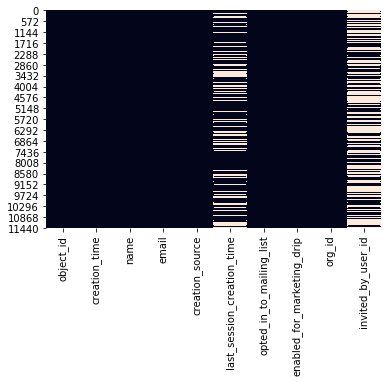

In [13]:
sns.heatmap(users.isnull(), cbar=False)

Are these values missing because the creation is the only login, or because they haven't been filled in correctly?

In [14]:
null_users = users[users['last_session_creation_time'].isnull()]['object_id'].unique()

In [15]:
usage[usage['user_id'].isin(null_users)]

,time_stamp,user_id,visited


...because the account creation is the only login.

impute last session creation time with account creation time if empty

In [16]:
users['last_session_creation_time'] = users['last_session_creation_time'].fillna(users['creation_time'])

Since user id starts at 1, a missing value will have a user id of 0 (no user invited the user to join).

In [17]:
users['invited_by_user_id'] = users['invited_by_user_id'].fillna(0)

In [18]:
users['invited_by_user_id'] = users['invited_by_user_id'].astype('category')

In [75]:
df = pd.merge(usage, users, left_on='user_id', right_on='object_id')
df = df.drop(columns=['object_id'])
df.head(30)

,time_stamp,user_id,visited,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,invited_self
0,2014-04-22 03:53:30,1,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,0
1,2013-11-15 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,0
2,2013-11-29 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,0
3,2013-12-09 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,0
4,2013-12-25 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,0
5,2013-12-31 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,0
6,2014-01-08 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,0
7,2014-02-03 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,0
8,2014-02-08 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,0
9,2014-02-09 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,0


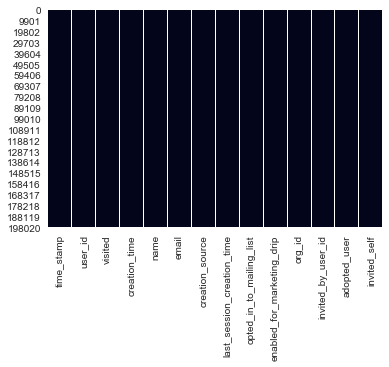

In [76]:
sns.heatmap(df.isnull(), cbar=False)

In [77]:
df.shape[0] - df.dropna().shape[0]

0

### feature architecture

We're interested in the number of unique login dates for each user, so we'll pull out the date as its own time period.

In [78]:
df['date'] = df['time_stamp'].dt.date

In [79]:
df.head()

,time_stamp,user_id,visited,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,invited_self,date
0,2014-04-22 03:53:30,1,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,0,2014-04-22
1,2013-11-15 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,0,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,0,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,0,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,0,2013-12-25


## exploration

How many inactive users were there?

In [80]:
inactive_users = users[users['creation_time'] == users['last_session_creation_time']]
inactive_users.shape

(6204, 12)

In [81]:
noninactive_users = users[users['creation_time'] != users['last_session_creation_time']]
noninactive_users.shape

(5796, 12)

Let's focus analysis on users who used logged in at least once.

In [82]:
names = noninactive_users['name'].unique()
df = df[df['name'].isin(names)]

In [83]:
df['name'].unique().shape

(5621,)

In [84]:
df = df.set_index('time_stamp')

In [85]:
df = df.sort_index()

In [86]:
grouped = df.groupby('user_id')['date'].resample('7d').nunique()

In [87]:
grouped_nonzero = grouped[grouped > 0]

The number of unique login dates for each seven-day period:

In [88]:
grouped_nonzero.head(10)

user_id  time_stamp
2        2013-11-15    1
         2013-11-29    1
         2013-12-06    1
         2013-12-20    1
         2013-12-27    1
         2014-01-03    1
         2014-01-31    1
         2014-02-07    3
         2014-02-14    1
         2014-03-07    2
Name: date, dtype: int64

In [89]:
at_least_three = grouped_nonzero[grouped_nonzero >=3]

In [90]:
adopted_users = at_least_three.index.get_level_values(level=0).unique()

In [91]:
adopted_users = list(adopted_users)

## add labels to user table

In [98]:
noninactive_users['adopted_user'] = np.where(noninactive_users['object_id'].isin(adopted_users), 1, 0)

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [100]:
noninactive_users['adopted_user'].dtype

dtype('int64')

In [101]:
noninactive_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,invited_self
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,2013-12-19 03:37:06,0,0,197,11241.0,0,0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,0.0,0,0


In [102]:
users = noninactive_users

#### sanity check

It should be the case that no adopted users have the same value in the timestamp and last session fields.

In [103]:
users[users['last_session_creation_time'] == users['creation_time']]['adopted_user'].unique()

array([], dtype=int64)

Looking good.

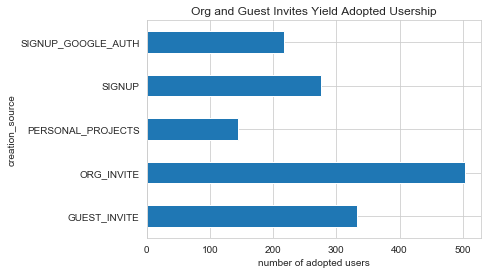

In [106]:
users.groupby('creation_source')['adopted_user'].sum().plot(kind='barh')
plt.xlabel('number of adopted users')
plt.title('Org and Guest Invites Yield Adopted Usership')
plt.savefig('plots/orgAndGuestInvitesYieldAdoptedUsership.png', bbox_inches='tight')

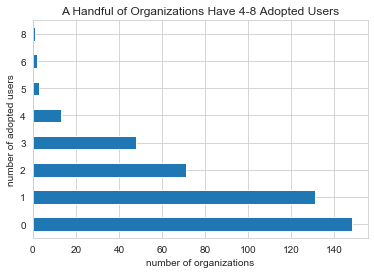

In [135]:
grouped = users[users['creation_source'] == 'ORG_INVITE'].groupby('org_id')['adopted_user'].sum()
grouped.value_counts().plot(kind='barh')
plt.xlabel('number of organizations')
plt.ylabel('number of adopted users')
plt.title('A Handful of Organizations Have 4-8 Adopted Users')
plt.savefig('plots/orgCountsByNumberOfAdoptedUsers.png', bbox_inches='tight')

About a fourth of users who logged on at least oncee after account creation are adopted users.

In [108]:
users[users['adopted_user'] == 1].shape[0]/users.shape[0]

0.25396825396825395

 It should the case that mailing list membership and market drip opt-in yield a higher chance of adopted usership. Is this true?

In [111]:
adopted_users = users[users['adopted_user'] == 1]

In [112]:
adopted_users['opted_in_to_mailing_list'].value_counts()

0    1087
1     385
Name: opted_in_to_mailing_list, dtype: int64

In [113]:
users[users['adopted_user'] == 0]['opted_in_to_mailing_list'].value_counts()

0    3218
1    1106
Name: opted_in_to_mailing_list, dtype: int64

In [114]:
adopted_users['enabled_for_marketing_drip'].value_counts()

0    1245
1     227
Name: enabled_for_marketing_drip, dtype: int64

In [115]:
users[users['adopted_user'] == 0]['enabled_for_marketing_drip'].value_counts()

0    3654
1     670
Name: enabled_for_marketing_drip, dtype: int64

Interesting. Neither list membership nor marketing opt-in correlate with adopted-usership in the expected way.

## feature architecture

Perhaps the day of the week someone created their account correlates with adopted usership?

In [116]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5796 entries, 1 to 11998
Data columns (total 12 columns):
object_id                     5796 non-null int64
creation_time                 5796 non-null datetime64[ns]
name                          5796 non-null category
email                         5796 non-null category
creation_source               5796 non-null category
last_session_creation_time    5796 non-null datetime64[ns]
opted_in_to_mailing_list      5796 non-null int64
enabled_for_marketing_drip    5796 non-null int64
org_id                        5796 non-null category
invited_by_user_id            5796 non-null category
adopted_user                  5796 non-null int64
invited_self                  5796 non-null int64
dtypes: category(5), datetime64[ns](2), int64(5)
memory usage: 1.3 MB


In [117]:
users['weekday_of_creation'] = users['creation_time'].dt.weekday_name.astype('category')

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Can someone invite themself to join?

In [118]:
users[users['invited_by_user_id'] == users['object_id']].head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,invited_self,weekday_of_creation
22,23,2012-08-17 08:30:27,Souza Alice,AliceAraujoSouza@gustr.com,ORG_INVITE,2012-08-18 08:30:27,1,0,6,23.0,0,1,Friday
49,50,2012-06-03 11:02:08,Oliveira Gabrielly,GabriellyAlmeidaOliveira@gmail.com,GUEST_INVITE,2012-10-23 11:02:08,0,0,61,50.0,0,1,Sunday
444,445,2012-07-24 03:26:27,Klausen Alfred,AlfredLKlausen@gmail.com,GUEST_INVITE,2014-05-26 03:26:27,0,0,289,445.0,1,1,Tuesday
509,510,2012-06-07 10:27:14,Larsen Jonathan,JonathanJLarsen@yahoo.com,GUEST_INVITE,2014-06-04 10:27:14,0,0,231,510.0,1,1,Thursday
539,540,2013-03-12 23:24:55,Wright Ethan,EthanWright@gmail.com,GUEST_INVITE,2013-10-22 23:24:55,0,0,380,540.0,1,1,Tuesday


In [119]:
users['invited_self'] = np.where(users['invited_by_user_id'] == users['object_id'], 1, 0)

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [120]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,invited_self,weekday_of_creation
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,0,Friday
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,0,Tuesday
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,0,Thursday
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,2013-12-19 03:37:06,0,0,197,11241.0,0,0,Tuesday
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,0.0,0,0,Sunday


## further exploration

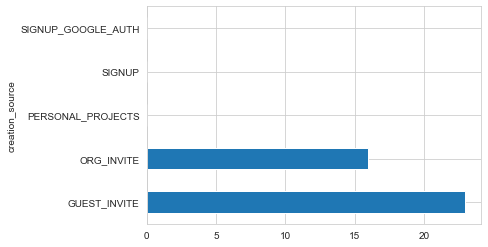

In [121]:
users[users['invited_self'] == 1].groupby('creation_source')['adopted_user'].sum().plot(kind='barh')

## random forests 

To find out which features matter most in predicting adoptd user status, we'll use many decision trees and have a look at the random forest's relative feature importance.

### consider unique labels for categorical data

In [122]:
# features
X=users[['creation_source',
         'opted_in_to_mailing_list', 
         'enabled_for_marketing_drip', 
         'invited_by_user_id',
         'org_id',
        ]]
# Labels
y=users['adopted_user']

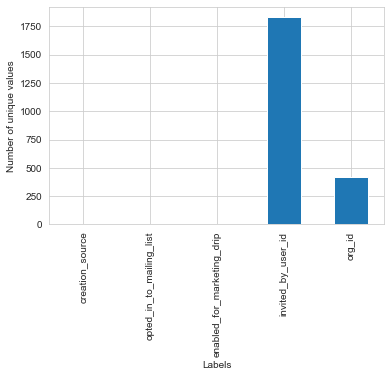

In [123]:
# Calculate number of unique values for each label: num_unique_labels
num_unique_labels = X.apply(pd.Series.nunique)

# Plot number of unique values for each label
num_unique_labels.plot(kind='bar')

# Label the axes
plt.xlabel('Labels')
plt.ylabel('Number of unique values')

# Display the plot
plt.show()

### binarizing categorical data

In [124]:
X = pd.get_dummies(X, prefix_sep='_')

In [125]:
X.shape

(5796, 2989)

In [126]:
X.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,invited_by_user_id_0.0,invited_by_user_id_3.0,invited_by_user_id_7.0,...,org_id_407,org_id_408,org_id_409,org_id_410,org_id_411,org_id_412,org_id_413,org_id_414,org_id_415,org_id_416
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [127]:
rf = RandomForestClassifier(n_estimators=10, class_weight='balanced')

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [129]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [130]:
y_pred = rf.predict(X_test)

In [132]:
# Compute the accuracy: accuracy
accuracy = float(np.sum(y_pred==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))
print(classification_report(y_test, y_pred))

accuracy: 0.713053
              precision    recall  f1-score   support

           0       0.76      0.91      0.83      1310
           1       0.29      0.12      0.17       429

    accuracy                           0.71      1739
   macro avg       0.53      0.51      0.50      1739
weighted avg       0.64      0.71      0.66      1739



The model predicts adopted usership with an accuracy of 84\%; however, accuracy isn't the best metric here, because we have relatively few positive labels for adopted usership.

In [133]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, rf.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index')

In [134]:
importances.sort_values(by=0, ascending=False).rename(columns={0:'importance'}).head(10)

,importance
opted_in_to_mailing_list,0.030624
enabled_for_marketing_drip,0.025589
creation_source_SIGNUP_GOOGLE_AUTH,0.008263
creation_source_SIGNUP,0.007252
creation_source_GUEST_INVITE,0.007113
creation_source_ORG_INVITE,0.006026
invited_by_user_id_0.0,0.005977
creation_source_PERSONAL_PROJECTS,0.005272
org_id_0,0.004928
org_id_9,0.004838


The random forest classifier's feature importance ranking shows which features the forest's decision trees found most informative with respect to prediction. Marketing status (mailing list and marketing drip) most significantly predicted adopted usership. After this, presence of personal initiative (person project or signup motivation) and then social incentive (guest or organization invite) play a role. Beyond this, the classifier found diminishing significance for membership in various organizations.

In [89]:
power_orgs = [35, 306, 62, 370]

In [93]:
users[users['org_id'].isin(power_orgs)]['adopted_user'].value_counts()

0    97
1    29
Name: adopted_user, dtype: int64

Users within these organizations are a bit more likely to be adopted users (20\% over the general 12\%).

In [97]:
users[users['creation_source'] == 'GUEST_INVITE']['adopted_user'].value_counts()

0    1831
1     332
Name: adopted_user, dtype: int64

Self-invitation ranks high as a factor against user adoption:

In [99]:
users[users['invited_by_user_id'] == 0]['adopted_user'].value_counts()

0    4947
1     636
Name: adopted_user, dtype: int64

# Clustering

In [173]:
adopted_users = users[users['adopted_user'] == 1]

In [174]:
# make username the index
adopted_users = adopted_users.reset_index().set_index('name')

In [175]:
adopted_users.head()

,index,object_id,creation_time,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,weekday_of_creation,invited_self
name,,,,,,,,,,,,,
Poole Matthew,1,2,2013-11-15 03:45:04,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,Friday,0
Santos Carla,9,10,2013-01-16 22:08:03,CarlaFerreiraSantos@gustr.com,ORG_INVITE,2014-06-03 22:08:03,1,1,318,4143.0,1,Wednesday,0
Helms Mikayla,19,20,2014-03-06 11:46:38,lqyvjilf@uhzdq.com,SIGNUP,2014-05-29 11:46:38,0,0,58,0.0,1,Thursday,0
Pinto Giovanna,41,42,2012-11-11 19:05:07,GiovannaCunhaPinto@cuvox.de,SIGNUP,2014-05-25 19:05:07,1,0,235,0.0,1,Sunday,0
Gomes Beatrice,42,43,2012-12-31 07:13:17,vgqmpljq@yyyxt.com,GUEST_INVITE,2013-04-15 07:13:17,0,0,63,149.0,1,Monday,0


In [121]:
# pull out categorical columns

In [246]:
# features
x_cols=adopted_users[[#'creation_source',
         'opted_in_to_mailing_list', 
         'enabled_for_marketing_drip', 
         #'invited_by_user_id',
         'org_id',
         #'adopted_user'
        ]]

In [247]:
# binarize frame
x_cols = pd.get_dummies(x_cols)

In [248]:
x_cols.shape

(1472, 419)

In [249]:
x_cols.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id_0,org_id_1,org_id_2,org_id_3,org_id_4,org_id_5,org_id_6,org_id_7,...,org_id_407,org_id_408,org_id_409,org_id_410,org_id_411,org_id_412,org_id_413,org_id_414,org_id_415,org_id_416
name,,,,,,,,,,,,,,,,,,,,,
Poole Matthew,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Santos Carla,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Helms Mikayla,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Pinto Giovanna,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gomes Beatrice,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


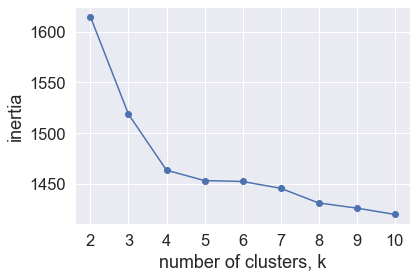

In [250]:
sns.set(font_scale=1.5)

# Import KMeans
from sklearn.cluster import KMeans

ks = range(2, 11)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(x_cols)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

4 appears to be the best number of clusters.

In [251]:
# train model on the best k
model = KMeans(n_clusters=4)
model.fit(x_cols)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

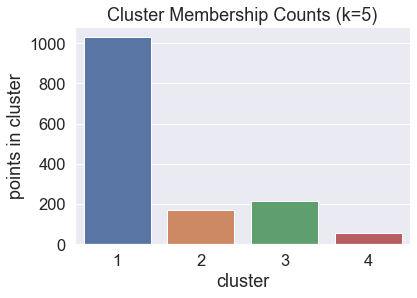

In [252]:
# count up category membership for labels

cluster_ids = model.labels_

counter = Counter(cluster_ids)
xs = [x + 1 for x in counter.keys()]
ys = list(counter.values())
sns.barplot(x=xs, y=ys,)
plt.xlabel('cluster')
plt.ylabel('points in cluster')
plt.title('Cluster Membership Counts (k=5)')
plt.show()

## Visualizing Clusters with PCA

In [253]:
# Import PCA
from sklearn.decomposition import PCA

# Create PCA instance: model
model = PCA(n_components=2)

# Apply the fit_transform method of model to grains: pca_features
pca_features = model.fit_transform(x_cols)

In [254]:
# make new dataframe with username customer name, cluster id, pca x, pca y columns
df = pd.DataFrame({'x': pca_features[:,0], 'y': pca_features[:,1], 'cluster': cluster_ids, 'name':x_cols.index})
df.head()

,x,y,cluster,name
0,-0.305460,0.010797,0,Poole Matthew
1,1.080356,0.296430,1,Santos Carla
2,-0.304343,0.015414,0,Helms Mikayla
3,0.529880,-0.549379,2,Pinto Giovanna
4,-0.297957,0.025213,0,Gomes Beatrice


In [193]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

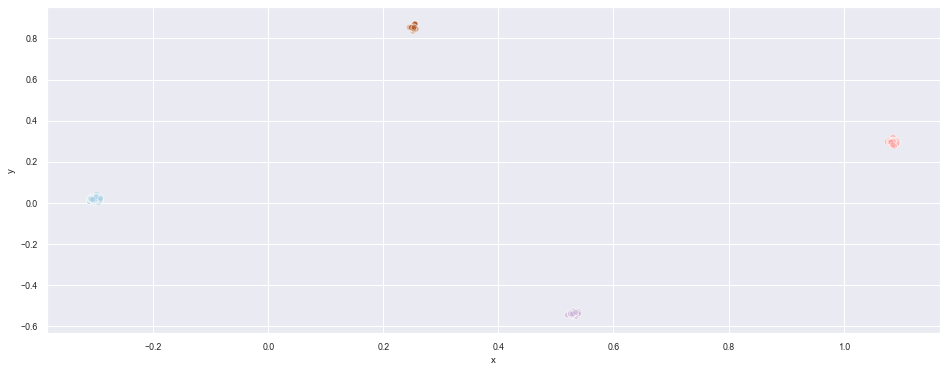

In [255]:
sns.set(font_scale=.8)
plt.figure(figsize=(16, 6))

sns.scatterplot(x=df['x'], y=df['y'], hue=df['cluster'], data=df, palette='Paired', legend=False, alpha=0.6)
# label_point(df['x'], df['y'], df['name'], plt.gca())
plt.show()

### Exploration of Each Cluster of Adopted Users

In [256]:
joined = df.merge(adopted_users, on='name')
joined.head()

,x,y,cluster,name,index,object_id,creation_time,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,weekday_of_creation,invited_self
0,-0.305460,0.010797,0,Poole Matthew,1,2,2013-11-15 03:45:04,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,Friday,0
1,1.080356,0.296430,1,Santos Carla,9,10,2013-01-16 22:08:03,CarlaFerreiraSantos@gustr.com,ORG_INVITE,2014-06-03 22:08:03,1,1,318,4143.0,1,Wednesday,0
2,-0.304343,0.015414,0,Helms Mikayla,19,20,2014-03-06 11:46:38,lqyvjilf@uhzdq.com,SIGNUP,2014-05-29 11:46:38,0,0,58,0.0,1,Thursday,0
3,0.529880,-0.549379,2,Pinto Giovanna,41,42,2012-11-11 19:05:07,GiovannaCunhaPinto@cuvox.de,SIGNUP,2014-05-25 19:05:07,1,0,235,0.0,1,Sunday,0
4,-0.297957,0.025213,0,Gomes Beatrice,42,43,2012-12-31 07:13:17,vgqmpljq@yyyxt.com,GUEST_INVITE,2013-04-15 07:13:17,0,0,63,149.0,1,Monday,0


### Cluster 0

In [257]:
zero = joined[joined['cluster'] == 0 ]

In [258]:
cols = ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip','org_id', 'invited_by_user_id', 'weekday_of_creation', 'invited_self']

In [259]:
for c in cols:
    print(zero[c].value_counts())

ORG_INVITE            352
GUEST_INVITE          236
SIGNUP                193
SIGNUP_GOOGLE_AUTH    156
PERSONAL_PROJECTS     108
Name: creation_source, dtype: int64
0    1041
1       4
Name: opted_in_to_mailing_list, dtype: int64
0    1042
1       3
Name: enabled_for_marketing_drip, dtype: int64
4      13
0      11
1      10
2      10
3      10
       ..
349     0
355     0
362     0
365     0
416     0
Name: org_id, Length: 417, dtype: int64
0.0        457
2354.0       4
6312.0       3
10624.0      3
879.0        3
          ... 
7541.0       0
7547.0       0
7552.0       0
7554.0       0
5885.0       0
Name: invited_by_user_id, Length: 2565, dtype: int64
Saturday     161
Friday       153
Tuesday      152
Wednesday    149
Monday       149
Thursday     143
Sunday       138
Name: weekday_of_creation, dtype: int64
0    1014
1      31
Name: invited_self, dtype: int64


People in this cluster are on both the marketing drip and mailing list and have largely signed up themselves.

### Cluster 1

In [261]:
one = joined[joined['cluster'] == 1 ]

In [262]:
cols = ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip','org_id', 'invited_by_user_id', 'weekday_of_creation', 'invited_self']

In [263]:
for c in cols:
    print(one[c].value_counts())

ORG_INVITE            61
GUEST_INVITE          38
SIGNUP                36
SIGNUP_GOOGLE_AUTH    25
PERSONAL_PROJECTS     13
Name: creation_source, dtype: int64
1    171
0      2
Name: opted_in_to_mailing_list, dtype: int64
1    170
0      3
Name: enabled_for_marketing_drip, dtype: int64
9      4
35     4
15     4
2      4
63     3
      ..
262    0
263    0
264    0
267    0
208    0
Name: org_id, Length: 417, dtype: int64
0.0        74
11386.0     2
9691.0      2
7431.0      2
5855.0      2
           ..
7757.0      0
7756.0      0
7753.0      0
7745.0      0
5885.0      0
Name: invited_by_user_id, Length: 2565, dtype: int64
Thursday     32
Saturday     27
Tuesday      25
Wednesday    24
Friday       23
Sunday       21
Monday       21
Name: weekday_of_creation, dtype: int64
0    166
1      7
Name: invited_self, dtype: int64


In [ ]:
zero['weekday_of_creation'].value_counts()

### Cluster 2

In [264]:
two = joined[joined['cluster'] == 2 ]

In [265]:
cols = ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip','org_id', 'invited_by_user_id', 'weekday_of_creation', 'invited_self']

In [266]:
for c in cols:
    print(two[c].value_counts())

ORG_INVITE            76
GUEST_INVITE          57
SIGNUP                42
SIGNUP_GOOGLE_AUTH    27
PERSONAL_PROJECTS     18
Name: creation_source, dtype: int64
1    216
0      4
Name: opted_in_to_mailing_list, dtype: int64
0    217
1      3
Name: enabled_for_marketing_drip, dtype: int64
5      4
82     4
7      4
235    3
52     3
      ..
258    0
259    0
260    0
261    0
0      0
Name: org_id, Length: 417, dtype: int64
0.0        87
5579.0      2
2367.0      2
7696.0      2
10628.0     2
           ..
7736.0      0
7730.0      0
7723.0      0
7721.0      0
5885.0      0
Name: invited_by_user_id, Length: 2565, dtype: int64
Sunday       44
Wednesday    36
Thursday     33
Saturday     31
Friday       27
Monday       26
Tuesday      23
Name: weekday_of_creation, dtype: int64
0    218
1      2
Name: invited_self, dtype: int64


### Cluster 3

In [267]:
three = joined[joined['cluster'] == 3 ]

In [268]:
cols = ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip','org_id', 'invited_by_user_id', 'weekday_of_creation', 'invited_self']

In [269]:
for c in cols:
    print(three[c].value_counts())

ORG_INVITE            21
SIGNUP                12
SIGNUP_GOOGLE_AUTH    10
GUEST_INVITE          10
PERSONAL_PROJECTS      7
Name: creation_source, dtype: int64
0    58
1     2
Name: opted_in_to_mailing_list, dtype: int64
1    57
0     3
Name: enabled_for_marketing_drip, dtype: int64
57     3
13     2
232    2
126    2
5      2
      ..
275    0
276    0
278    0
279    0
0      0
Name: org_id, Length: 417, dtype: int64
0.0       29
5545.0     2
2527.0     2
7597.0     1
7269.0     1
          ..
7837.0     0
7836.0     0
7825.0     0
7821.0     0
5885.0     0
Name: invited_by_user_id, Length: 2565, dtype: int64
Thursday     12
Friday       11
Monday        9
Sunday        8
Wednesday     7
Tuesday       7
Saturday      6
Name: weekday_of_creation, dtype: int64
0    58
1     2
Name: invited_self, dtype: int64


In [138]:
users[users['creation_source'] == 'PERSONAL_PROJECTS']['weekday_of_creation'].value_counts()

Friday       97
Thursday     75
Saturday     72
Wednesday    69
Sunday       66
Monday       66
Tuesday      62
Name: weekday_of_creation, dtype: int64